**Директория на ShadBox:**

/hse/amironov/Task7

**Докинг низкомолекулярных лигандов в структуру белка**

In [2]:
import numpy as np
import pandas as pd
import copy

# Отображение структур
import IPython.display
import ipywidgets
from IPython.display import display,display_svg,SVG,Image

# Open Drug Discovery Toolkit
import oddt
import oddt.docking
import oddt.interactions

# Органика
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

import pmx # Модуль для манипулирования pdb

In [4]:
pdb=pmx.Model('good.B99990001.pdb')

for r in pdb.residues[135:]:
    print r #посмотрим остатки

<Molecule: id = 136 name = THR chain_id =    natoms = 7>
<Molecule: id = 137 name = ASP chain_id =    natoms = 8>
<Molecule: id = 138 name = VAL chain_id =    natoms = 7>
<Molecule: id = 139 name = GLN chain_id =    natoms = 9>
<Molecule: id = 140 name = ALA chain_id =    natoms = 5>
<Molecule: id = 141 name = TRP chain_id =    natoms = 14>
<Molecule: id = 142 name = ILE chain_id =    natoms = 8>
<Molecule: id = 143 name = ARG chain_id =    natoms = 11>
<Molecule: id = 144 name = GLY chain_id =    natoms = 4>
<Molecule: id = 145 name = CYS chain_id =    natoms = 6>
<Molecule: id = 146 name = ARG chain_id =    natoms = 11>
<Molecule: id = 147 name = LEU chain_id =    natoms = 9>
<Molecule: id = 148 name = NAG chain_id =    natoms = 14>
<Molecule: id = 149 name = NAG chain_id =    natoms = 14>
<Molecule: id = 150 name = NDG chain_id =    natoms = 15>


Последние 3 остатка (NAG, NAG, NDG) являются присоединенным лигандом

In [6]:
# создание объектов белок и лиганда
newpdb = pdb.copy()
for r in newpdb.residues[-3:]:
    newpdb.remove_residue(r)

lig = pdb.copy()
del lig.residues[:-3]

In [14]:
s = np.zeros(3)
for a in lig.atoms:
    s = s + a.x 
ligand_center = s/len(lig.atoms)
ligand_center

array([ 46.78908234,  31.34831409,  23.29865025])

In [8]:
newpdb.writePDB('newPDB.pdb')

**Готовим белок для докинга**

In [9]:
prot = oddt.toolkit.readfile('pdb','newPDB.pdb').next()

prot.OBMol.AddPolarHydrogens()
prot.OBMol.AutomaticPartialCharge()

True

**Лиганды для докинга**

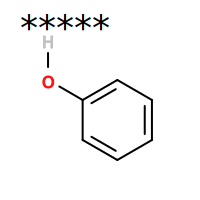

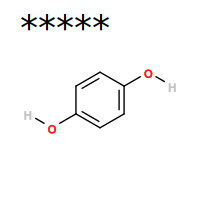

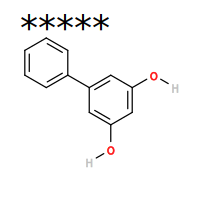

In [11]:
smiles = ['c1cccc(O)c1', 'c1c(O)ccc(O)c1','c1(O)cc(c2ccccc2)cc(O)c1']
mols= []
images =[]

for s in smiles:
    m = oddt.toolkit.readstring('smi', s)
    if not m.OBMol.Has3D(): 
        m.make3D(forcefield='mmff94', steps=150)
        m.removeh()
        m.OBMol.AddPolarHydrogens()

    mols.append(m)
    ###with print m.OBMol.Has3D() was found that:
    ### deep copy needed to keep 3D , write svg make mols flat
    images.append((SVG(copy.deepcopy(m).write('svg'))))

display_svg(*images)

In [15]:
xx = ligand_center[0]
yy = ligand_center[1]
zz = ligand_center[2]

In [16]:
dock_obj= oddt.docking.AutodockVina.autodock_vina(
    protein=prot,size=(20,20,20),center=[xx,yy,zz],
    executable='/usr/bin/vina',autocleanup=True, num_modes=9)
print dock_obj.tmp_dir

/tmp/autodock_vina_3I5sBz


In [17]:
print('Center coordinates')
print " ".join(dock_obj.params[0:6])
print ("№ of points")
print " ".join(dock_obj.params[6:12])
print ("Number Of CPU Cores")
print " ".join(dock_obj.params[12:14])
print("Exhaustiveness parameter")
print " ".join(dock_obj.params[14:16])
print("Number of conformations generated by Autodock Vina")
print " ".join(dock_obj.params[16:18])
print("Energy range cutoff for Autodock Vina")
print " ".join(dock_obj.params[18:20])

Center coordinates
--center_x 46.789082343 --center_y 31.3483140917 --center_z 23.2986502547
№ of points
--size_x 20 --size_y 20 --size_z 20
Number Of CPU Cores
--cpu 1
Exhaustiveness parameter
--exhaustiveness 8
Number of conformations generated by Autodock Vina
--num_modes 9
Energy range cutoff for Autodock Vina
--energy_range 3


In [18]:
res = dock_obj.dock(mols,prot)